In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sorting
import random
from sklearn.preprocessing import MinMaxScaler
import math
from collections import Counter,OrderedDict

## Importing Data 

In [2]:
movie_data=pd.read_csv('/home/acer/Downloads/ml-latest-small/movies.csv')
links=pd.read_csv('/home/acer/Downloads/ml-latest-small/links.csv')
ratings=pd.read_csv('/home/acer/Downloads/ml-latest-small/ratings.csv')
tags=pd.read_csv('/home/acer/Downloads/ml-latest-small/tags.csv')

In [3]:
user_rating=np.zeros((len(np.unique(ratings['userId'])),len(np.unique(ratings['movieId']))))
train=np.zeros(user_rating.shape)
test=np.zeros(user_rating.shape)

# User ratings

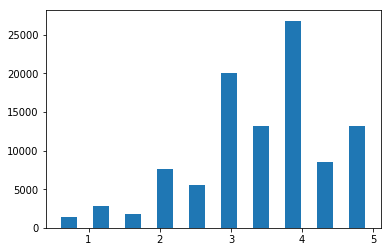

In [4]:
plt.hist(ratings['rating'],rwidth=0.5)
plt.show()

In [5]:
print("Number of Users :",len(np.unique(ratings["userId"])))
print("Number of movies :",len(np.unique(movie_data["movieId"])))

Number of Users : 610
Number of movies : 9742


In [6]:
print("Movies with highest number of user ratings :")
for i in sorted(Counter(ratings["movieId"]).items(), key=lambda x: x[1],reverse=True)[:15]:
    print(movie_data["title"][i[0]])

Movies with highest number of user ratings :
Age of Innocence, The (1993)
I Love Trouble (1994)
Virtuosity (1995)
Cemetery Man (Dellamorte Dellamore) (1994)
Teenage Mutant Ninja Turtles II: The Secret of the Ooze (1991)
Quiz Show (1994)
Terminal Velocity (1994)
Jupiter's Wife (1994)
Last Dance (1996)
Aristocats, The (1970)
Billy Elliot (2000)
Jumanji (1995)
Picture Perfect (1997)
Georgia (1995)
Autumn in New York (2000)


In [7]:
print("User who gave more ratings (User Number,Number of movies) :")
sorted(Counter(ratings["userId"]).items(), key=lambda x: x[1],reverse=True)[:15]

User who gave more ratings (User Number,Number of movies) :


[(414, 2698),
 (599, 2478),
 (474, 2108),
 (448, 1864),
 (274, 1346),
 (610, 1302),
 (68, 1260),
 (380, 1218),
 (606, 1115),
 (288, 1055),
 (249, 1046),
 (387, 1027),
 (182, 977),
 (307, 975),
 (603, 943)]

# User Rating Matrix

In [8]:
for i in np.unique(ratings['userId']):
    k=ratings[ratings['userId']==i]
    for j in range(len(k)):
        if (k['movieId'].iloc[j]-1<=9742):
            user_rating[i-1,k['movieId'].iloc[j]-1]=k['rating'].iloc[j]

## Test Train split

In [9]:
t=int(np.count_nonzero(user_rating)*80/100)
non_zero=[]
for i in range(user_rating.shape[0]):
    for j in range(user_rating.shape[1]):
        if(user_rating[i,j]!=0):
            non_zero.append([i,j])
k=0
while(k<=t):
    i=random.randint(1,len(non_zero)-1)
    train[non_zero[i][0],non_zero[i][1]]=user_rating[non_zero[i][0],non_zero[i][1]]
    non_zero.remove(non_zero[i])
    k=k+1

In [10]:
train

array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [2.5, 2. , 2. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [5. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [11]:
for i in non_zero:
    test[i[0],i[1]]=user_rating[i[0],i[1]]

In [12]:
test

array([[4., 0., 4., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Matrix factorization

In [18]:
user=np.random.rand(user_rating.shape[0],5)
movies=np.random.randint(4,size=(user_rating.shape[1],5))
I=np.zeros(user_rating.shape)
Itest=np.zeros(user_rating.shape)
Itrain=np.zeros(user_rating.shape)

In [29]:
for i in range(user_rating.shape[0]):
    for j in range(user_rating.shape[1]):
        if(user_rating[i][j]!=0):
            I[i][j]=1

In [78]:
def gradient(user,movies,result):
    user=user+2*0.000001*(result.dot(movies))
    movies=movies+2*0.000001*(result.T.dot(user))
    return(user,movies)
def prediction(user,movies,user_r,k):
    error=[]
    for i in range(k):
        result=np.multiply((user_r-user.dot(movies.T)),I)
        user,movie=gradient(user,movies,result)
        error.append(np.sum(np.square(result)))
    return(error,user,movies)

In [79]:
def accuracy (user,movies,data,k):
    error1=prediction(user,movies,data,k)
    result1=error1[1].dot(error1[2].T)
    e=0
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if(data[i,j]!=0):
                e+=(data[i,j]-result1[i,j])**2
    return(math.sqrt(e/np.count_nonzero(data)),result1)

In [32]:
train_ac,train_result=accuracy(user,movies,train,1000)

In [33]:
train_ac

1.7478702070970782

In [34]:
test_ac,test_result=accuracy(user,movies,test,1000)

In [35]:
train_ac

1.7478702070970782

## Regularised Matrix Factorization

In [36]:
beta=0.0001
def prediction2(user,movies,user_r,k):
    error=[]
    for i in range(k):
        result=np.square(np.multiply((user_r-user.dot(movies.T)),I))+beta*((np.sum(np.square(user))+(np.sum(np.square(movies)))))
        user,movies=gradient2(user,movies,result)
        error.append(np.sum(1/(2*user_r.shape[0])*np.square(result)))
    return(error,user,movies)

def gradient2(user,movies,result):
    user=user-0.000000001*(2*(result.dot(movies))+2*beta*(np.sum(user)))
    movies=movies-0.00000001*(2*(result.T.dot(user))+2*beta*np.sum(movies))
    return(user,movies)

In [37]:
def accuracy_regularised(user,movies,data,k):
    error2=prediction2(user,movies,data,k)
    result2=error2[1].dot(error2[2].T)
    e=0
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if(data[i,j]!=0):
                e+=(data[i,j]-result2[i,j])**2
    return(math.sqrt(e/np.count_nonzero(data)),result2)

In [38]:
train_ac_r,train_result_re=accuracy_regularised(user,movies,train,1000)
test_ac_r,test_result_re=accuracy_regularised(user,movies,test,1000)

In [39]:
train_ac_r

3.5431356926701305

In [40]:
test_ac_r

3.554369200787348

## Sliding window 

In [44]:
def gradient_sliding_w(user,movies,result):
    user=user+2*0.0000001*(result.dot(movies))
    movies=movies+2*0.0000001*(result.T.dot(user))
    return(user,movies)
def prediction_sliding_w(user,movies,user_r,k,win_size):
    error=[]
    win=[]
    for i in range(k):
        result=np.multiply((user_r-user.dot(movies.T)),I)
        user,movie=gradient_sliding_w(user,movies,result)
        e=np.sum(np.square(result))
        error.append(e)
        if(i<win_size):
            win.append(e)
        else:
            mean1=sum(win)/win_size
            del win[0]
            win.append(e)
            mean2=sum(win)/win_size
            if(mean1<mean2):
                break
            else:
                continue
    return(error,user,movies)

In [45]:
def accuracy_sliding_w(user,movies,data,k,win_size):
    error1=prediction_sliding_w(user,movies,data,k,win_size)
    result1=error1[1].dot(error1[2].T)
    e=0
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if(data[i,j]!=0):
                e+=(data[i,j]-result1[i,j])**2
    return(math.sqrt(e/np.count_nonzero(data)),result1)

In [46]:
train_ac_sw,train_result_sw=accuracy_sliding_w(user,movies,train,2000,10)
test_ac_sw,test_result_sw=accuracy_sliding_w(user,movies,test,2000,10)

In [47]:
train_ac_sw

1.7116999377971749

In [48]:
test_ac_sw

2.4341173707371397

# Line Search 

In [49]:
def gradient_line_search(user,movies,result,alpha):
    user=user+2*alpha*(result.dot(movies))
    movies=movies+2*alpha*(result.T.dot(user))
    return(user,movies)
def prediction_line_search(user,movies,user_r,k,threshold):
    error=[]
    jold=0
    jnew=0
    alpha=1/9000
    for i in range(k):
        result=np.multiply((user_r-user.dot(movies.T)),I)
        jnew=np.sum(np.square(result))
        error.append([jnew])
        if(abs(jold-jnew)>threshold):
            alpha=alpha/10
            user,movie=gradient_line_search(user,movies,result,alpha)
        else:
            break
        jold=jnew
    return(error,user,movies)

In [50]:
def accuracy_line_search(user,movies,data,k,win_size):
    error1=prediction_line_search(user,movies,data,k,win_size)
    result1=error1[1].dot(error1[2].T)
    e=0
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if(data[i,j]!=0):
                e+=(data[i,j]-result1[i,j])**2
    return(math.sqrt(e/np.count_nonzero(data)),result1)

In [51]:
train_ac_ls,train_result_ls=accuracy_line_search(user,movies,train,1000,0.001)
test_ac_ls,test_result_ls=accuracy_line_search(user,movies,test,1000,0.001)

In [52]:
train_ac_ls

1.9513278651016523

In [53]:
test_ac_ls

1.8970107359135833

# PSO

In [54]:
def update_param(param,c1,alpha):
    user=param['user']+alpha*(c1*param['du']-(1-c1)*(param['Best_user']-param['user']))
    movies=param['movies']+alpha*(c1*param['dm']-(1-c1)*(param['Best_movies']-param['movies']))
    return(user,movies)
def gradient(user,movies,result):
    du=result.dot(movies)
    dw=result.T.dot(user)
    return(du,dw)
def cost(user,movies,user_r,k,c1,alpha):
    error=[]
    min_cost=100000000000
    best_u=user
    best_m=movies
    for i in range(k):
        result=np.multiply((user_r-user.dot(movies.T)),I)
        error.append(np.sum(np.square(result)))
        if(min_cost>error[i]):
            min_cost=error[i]
            best_u=user
            best_m=movies
        du,dm=gradient(user,movies,result)
        param={'du':du,'dm':dm,'user':user,'movies':movies,'result':result,'Best_user':best_u,'Best_movies':best_m}
        user,movies=update_param(param,c1,alpha)
    return(error,user,movies)

In [55]:
def accuracy_pso(user,movies,data,k,c1,alpha):
    error1=cost(user,movies,data,k,c1,alpha)
    result1=error1[1].dot(error1[2].T)
    e=0
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if(data[i,j]!=0):
                e+=(data[i,j]-result1[i,j])**2
    return(math.sqrt(e/np.count_nonzero(data)),result1)

In [56]:
train_ac_pso,train_result_pso=accuracy_pso(user,movies,train,1000,0.9,0.0001)
test_ac_pso,test_result_pso=accuracy_pso(user,movies,test,1000,0.9,0.0001)

In [57]:
train_ac_pso

1.1602204835297218

In [58]:
test_ac_pso

2.8786025129376953

# Recommendation

In [59]:
def find_movie(rating_matrix):
    l=[]
    for i in range(rating_matrix.shape[0]):
        t=[]
        q=sorted(range(len(rating_matrix[0])), key=lambda k: rating_matrix[i][k])
        q.reverse()
        for j in q:
            if(user_rating[i,j]==0):
                t.append(j)
        l.append(t)
    return(l)

In [60]:
def recommendation(user,n,l):
    i=0
    while(n>=0):
        print(l[user][i],"    ",movie_data["title"][l[user][i]])
        i=i+1
        n=n-1

In [81]:
t=prediction(user,movies,user_rating,1000)
predicted_matrix=t[1].dot(t[2].T)

In [82]:
recommendation(2,5,find_movie(predicted_matrix))

8478      Hercules (2014)
6047      Chicken Little (2005)
4318      Legal Eagles (1986)
3668      Italian for Beginners (Italiensk for begyndere) (2000)
1589      Autumn Sonata (Höstsonaten) (1978)
8908      The Star Wars Holiday Special (1978)


In [63]:
t_re=prediction2(user,movies,user_rating,100)
predicted_matrix_re=t_re[1].dot(t_re[2].T)

In [64]:
recommendation(2,5,find_movie(predicted_matrix_re))

8478      Hercules (2014)
6047      Chicken Little (2005)
4318      Legal Eagles (1986)
3668      Italian for Beginners (Italiensk for begyndere) (2000)
1589      Autumn Sonata (Höstsonaten) (1978)
8908      The Star Wars Holiday Special (1978)


In [65]:
t_sw=prediction_sliding_w(user,movies,user_rating,1000,15)
predicted_matrix_sw=t_sw[1].dot(t_sw[2].T)

In [66]:
recommendation(2,5,find_movie(predicted_matrix_sw))

8478      Hercules (2014)
6047      Chicken Little (2005)
4318      Legal Eagles (1986)
3668      Italian for Beginners (Italiensk for begyndere) (2000)
1589      Autumn Sonata (Höstsonaten) (1978)
8908      The Star Wars Holiday Special (1978)


In [67]:
t_ls=prediction_line_search(user,movies,user_rating,1000,0.00001)
predicted_matrix_ls=t_ls[1].dot(t_ls[2].T)

In [68]:
recommendation(2,5,find_movie(predicted_matrix_ls))

8478      Hercules (2014)
6047      Chicken Little (2005)
4318      Legal Eagles (1986)
3668      Italian for Beginners (Italiensk for begyndere) (2000)
1589      Autumn Sonata (Höstsonaten) (1978)
8908      The Star Wars Holiday Special (1978)


In [69]:
t_pso=cost(user,movies,user_rating,1000,0.9,0.00001)
predicted_matrix_pso=t_pso[1].dot(t_pso[2].T)

In [70]:
recommendation(2,5,find_movie(predicted_matrix_pso))

7828      Miss Nobody (2010)
2199      Drunken Master (Jui kuen) (1978)
2968      Little Nicky (2000)
3329      Frantic (1988)
2482      City Lights (1931)
6779      Kit Kittredge: An American Girl (2008)


In [71]:
def show(mat):
    rate=[]
    for i in range(user_rating.shape[0]):
        for j in range(user_rating.shape[1]):
            if(user_rating[i][j]!=0):
                rate.append(mat[i][j])
    m=min(rate)
    n=max(rate)
    plt.hist([(r-m)/(n-m) for r in rate],rwidth=0.5)
    plt.show()

Using Matrix Factorisation :


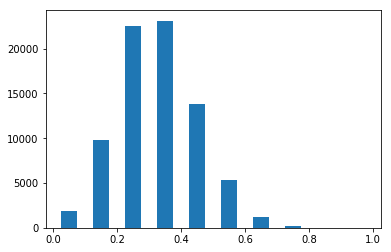

In [84]:
print("Using Matrix Factorisation :")
show(predicted_matrix)

Using Regularisation :


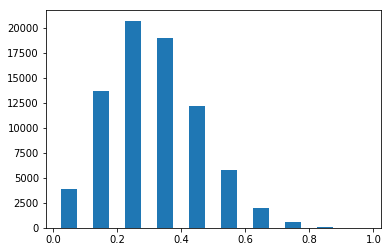

In [85]:
print("Using Regularisation :")
show(predicted_matrix_re)

Using Sliding Window :


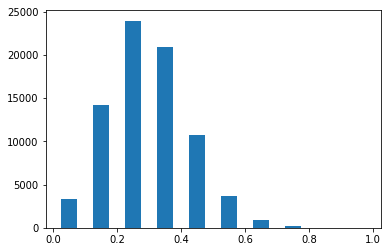

In [86]:
print("Using Sliding Window :")
show(predicted_matrix_sw)

Using line search :


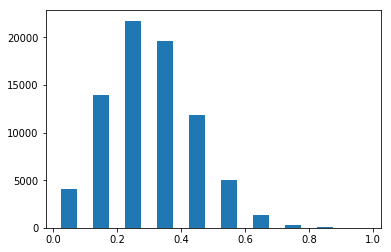

In [87]:
print("Using line search :")
show(predicted_matrix_ls)